In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2023-08-01 16:32:22 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.8

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


In [ ]:
versioninfo()

Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, broadwell)
  Threads: 2 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  LD_PRELOAD = /usr/lib/x86_64-linux-gnu/libtcmalloc.so.4
  JULIA_NUM_THREADS = 2



<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />

In [ ]:
using Pkg

In [ ]:
Pkg.add(url="https://github.com/JuliaQuantumControl/GRAPELinesearchAnalysis.jl.git")

In [ ]:
Pkg.add("QuantumControl")

In [ ]:
using GRAPELinesearchAnalysis

In [ ]:
using QuantumControl

In [ ]:
Pkg.add("QuantumControlBase")

   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [f10a33bc] + QuantumControlBase v0.8.3
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [ ]:
using QuantumControlBase

In [ ]:
ϵ1(t) = 0.2 * QuantumControl.Shapes.flattop(t, T=300, t_rise=0.3, func=:blackman);
ϵ2(t) = 0.2 * QuantumControl.Shapes.flattop(t, T=300, t_rise=0.3, func=:blackman);

In [ ]:
"""Two-level-system Hamiltonian."""
function hamiltonian(Ω1=1.0, ϵ1=ϵ1,ϵ2=ϵ2, Ω2=1.0, J=0.01)
    Iσ̂_z = ComplexF64[
        1  0  0  0
        0 -1  0  0
        0  0  1  0
        0  0  0  -1
    ]
    Iσ̂_x = ComplexF64[
        0  1  0  0
        1  0  0  0
        0  0  0  1
        0  0  1  0
    ]
    σ̂_xI = ComplexF64[
        0  0  1  0
        0  0  0  1
        1  0  0  0
        0  1  0  0
    ]
    σ̂_zI = ComplexF64[
        1  0  0  0
        0  1  0  0
        0  0 -1  0
        0  0  0  -1
    ]
    σ̂_x_x = ComplexF64[
        0  0  0  1
        0  0  1  0
        0  1  0  0
        1  0  0  0
    ]
    σ̂_y_y = ComplexF64[
        0  0  0 -1
        0  0  1  0
        0  1  0  0
       -1  0  0  0
    ]
    σ̂_z_z = ComplexF64[
        1  0  0  0
        0 -1  0  0
        0  0 -1  0
        0  0  0  1
    ]
    Ĥ₀ = -0.5 * (Ω1 * Iσ̂_z + Ω2 * σ̂_zI) + J * (σ̂_z_z)
    Ĥ₁ = Iσ̂_x
    Ĥ2 = σ̂_xI
    return (Ĥ₀, (Ĥ₁, ϵ1), (Ĥ2, ϵ2))
end;

In [ ]:
H = hamiltonian();

In [ ]:
T = 300
N = 3000
dt = T/N
omega1=1
omega2=1
J=0.01

ampl0=0.2

psi_11= [0, 0, 0, 1]
    Iσ̂_z = ComplexF64[
        1  0  0  0
        0 -1  0  0
        0  0  1  0
        0  0  0  -1
    ]
    Iσ̂_x = ComplexF64[
        0  1  0  0
        1  0  0  0
        0  0  0  1
        0  0  1  0
    ]
    σ̂_xI = ComplexF64[
        0  0  1  0
        0  0  0  1
        1  0  0  0
        0  1  0  0
    ]
    σ̂_zI = ComplexF64[
        1  0  0  0
        0  1  0  0
        0  0 -1  0
        0  0  0  -1
    ]
    σ̂_x_x = ComplexF64[
        0  0  0  1
        0  0  1  0
        0  1  0  0
        1  0  0  0
    ]
    σ̂_y_y = ComplexF64[
        0  0  0 -1
        0  0  1  0
        0  1  0  0
       -1  0  0  0
    ]
    σ̂_z_z = ComplexF64[
        1  0  0  0
        0 -1  0  0
        0  0 -1  0
        0  0  0  1
    ]

4×4 Matrix{ComplexF64}:
 1.0+0.0im   0.0+0.0im   0.0+0.0im  0.0+0.0im
 0.0+0.0im  -1.0+0.0im   0.0+0.0im  0.0+0.0im
 0.0+0.0im   0.0+0.0im  -1.0+0.0im  0.0+0.0im
 0.0+0.0im   0.0+0.0im   0.0+0.0im  1.0+0.0im

In [ ]:
tlist = collect(range(0, 300, length=3000));

In [ ]:
Pkg.add("Plots")
using Plots
Plots.default(
    linewidth               = 3,
    size                    = (550, 300),
    legend                  = :right,
    foreground_color_legend = nothing,
    background_color_legend = RGBA(1, 1, 1, 0.8)
)

   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [91a5bcdd] + Plots v1.38.17
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [ ]:
function ket(label)
    result = Dict("00" => Vector{ComplexF64}([1, 0, 0, 0]), "01" => Vector{ComplexF64}([0, 1, 0, 0]), "10" => Vector{ComplexF64}([0, 0, 1, 0]), "11" => Vector{ComplexF64}([0, 0, 0, 1]))
    return result[string(label)]
end;

In [ ]:
basis = [ket("00"),ket("01"),ket("10"),ket("11")];

In [ ]:
CNOT = [
    1  0  0  0
    0  1  0  0
    0  0  0  1
    0  0  1  0
];

In [ ]:
basis_tgt = transpose(CNOT) * basis;

In [ ]:
objectives = [Objective(initial_state = psi, target_state = psitgt, generator = H) for
    (psi, psitgt) ∈ zip(basis, basis_tgt)];

objectives


4-element Vector{Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}}}}:
 Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}}}(…)
 Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}}}(…)
 Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}}}(…)
 Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}}}(…)

In [ ]:
using LinearAlgebra

In [ ]:
U_guess = [basis[i] ⋅ guess_states[j] for i = 1:4, j = 1:4];

In [ ]:
problem = ControlProblem(
    objectives=objectives,
    tlist=tlist,
    pulse_options=Dict(),
    iter_stop=500,
    J_T=QuantumControl.Functionals.J_T_sm,
    check_convergence=res -> begin
        ((res.J_T < 1e-3) && (res.converged = true) && (res.message = "J_T < 10⁻³"))
    end,
);

In [ ]:
function plot_population(pop00::Vector, pop01::Vector, pop10::Vector,pop11::Vector,tlist)
    fig = plot(tlist, pop00, label="00", xlabel="time", ylabel="population")
    plot!(fig, tlist, pop01; label="01")
    plot!(fig, tlist, pop10; label="10")
    plot!(fig, tlist, pop11; label="11")
end;

In [ ]:
Pkg.add("QuantumPropagators")
using QuantumPropagators

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [ ]:
function store_pulses(wrk, iteration, _...)
    L = length(wrk.controls)
    ϵ_opt = reshape(wrk.pulsevals, L, :)
    opt_pulses = [QuantumControl.Controls.discretize_on_midpoints(ϵ_opt[l, :], tlist) for l=1:L]
    return Tuple(opt_pulses)
end

store_pulses (generic function with 1 method)

In [ ]:
Pkg.add("GRAPE")
using GRAPE

   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [6b52fcaf] + GRAPE v0.5.4
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [ ]:
wrk=GRAPE.GrapeWrk(problem; )

GrapeWrk{}(Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}}}[Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}}}(…), Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}}}(…), Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}}}(…), Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}}}(…)], Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}}}[Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}}}(…), Objective{Vector{Comple

In [ ]:
opt_result_LBFGSB = optimize(

    problem,
    method = :grape,
    force = true,
    info_hook = QuantumControlBase.chain_infohooks(

        QuantumControl.GRAPE.print_table,
        store_pulses
    )
);

 iter.        J_T     |∇J_T|       ΔJ_T   FG(F)    secs
     0   9.69e-01   5.82e-01        n/a    1(0)     1.2
     1   4.72e-01   1.70e+00  -4.96e-01    1(0)     0.4
     2   2.51e-01   1.30e+00  -2.21e-01    1(0)     0.5
     3   1.31e-01   1.05e+00  -1.21e-01    2(0)     0.9
     4   5.85e-02   5.43e-01  -7.21e-02    2(0)     1.0
     5   3.33e-02   3.03e-01  -2.52e-02    1(0)     0.5
     6   2.01e-02   1.66e-01  -1.32e-02    1(0)     0.5
     7   1.35e-02   1.42e-01  -6.59e-03    1(0)     0.5
     8   1.07e-02   3.17e-01  -2.77e-03    1(0)     0.6
     9   4.42e-03   1.27e-01  -6.32e-03    1(0)     0.8
    10   1.74e-03   7.77e-02  -2.69e-03    1(0)     0.9
    11   1.46e-04   5.68e-02  -1.59e-03    1(0)     0.5


In [ ]:
opt_result_LBFGSB

GRAPE Optimization Result
-------------------------
- Started at 2023-08-01T17:38:45.615
- Number of objectives: 4
- Number of iterations: 11
- Number of pure func evals: 0
- Number of func/grad evals: 14
- Value of functional: 1.46149e-04
- Reason for termination: J_T < 10⁻³
- Ended at 2023-08-01T17:38:53.921 (8 seconds, 306 milliseconds)


In [ ]:
function plot_pulse1(pulse::Vector, tlist)
    plot(tlist, pulse, xlabel="time", ylabel="amplitude" , legend=false)

    ylabel!("Sigma X pulse amplitude")
end

plot_control(ϵ::T, tlist) where {T<:Function} = plot_control([ϵ(t) for t in tlist], tlist);

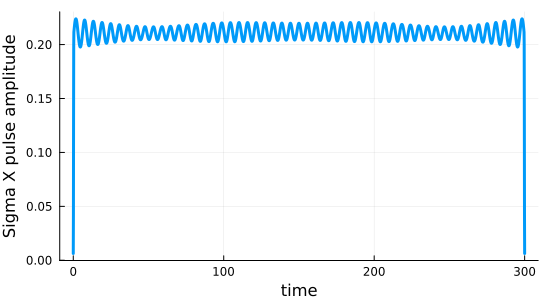

In [ ]:
fig2 = plot_pulse1(opt_result_LBFGSB.optimized_controls[1], tlist)

In [ ]:
function plot_pulse2(pulse::Vector, tlist)
    plot(tlist, pulse, xlabel="time", ylabel="amplitude" , legend=false)

    ylabel!("Sigma Y pulse amplitude")
end

plot_control(ϵ::T, tlist) where {T<:Function} = plot_control([ϵ(t) for t in tlist], tlist);

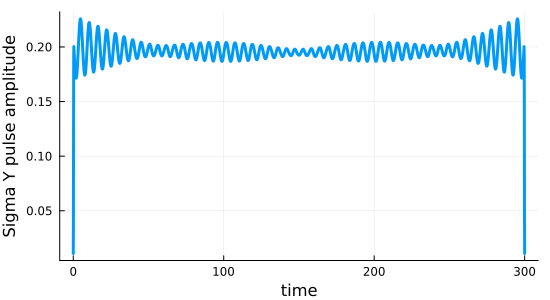

In [ ]:
fig2 = plot_pulse2(opt_result_LBFGSB.optimized_controls[2], tlist)

In [ ]:
all_pulses=opt_result_LBFGSB.records

12-element Vector{Tuple}:
 ([-2.7755575615628915e-18, 0.06805238611310968, 0.17867033500609486, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2  …  0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.17867033500606494, 0.06805238611313418, -2.7755575615628915e-18], [-2.7755575615628915e-18, 0.06805238611310968, 0.17867033500609486, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2  …  0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.17867033500606494, 0.06805238611313418, -2.7755575615628915e-18])
 ([0.014982447383787971, 0.08380180229206174, 0.1950468774249891, 0.21687955171436477, 0.21726076802971256, 0.21751643340130297, 0.21764338353184604, 0.2176399941875154, 0.21750620494149786, 0.21724352396166136  …  0.2172435239616646, 0.21750620494150116, 0.2176399941875187, 0.21764338353184937, 0.21751643340130633, 0.21726076802971594, 0.21687955171436818, 0.19504687742496263, 0.0838018022920897, 0.014982447383791425], [0.0007406176878034917, 0.06842150500316789, 0.1786607431796027, 0.1996026088099217, 0.1992079476518314, 0.19881071815285367, 0.19

In [ ]:
ket_11= Vector{ComplexF64}([0, 0, 0, 1])
ket_00= Vector{ComplexF64}([1, 0, 0, 0])
ket_01= Vector{ComplexF64}([0, 1, 0, 0])
ket_10= Vector{ComplexF64}([0, 0, 1, 0])
bra_00=reshape(ket_00, (4, 1))
bra_01=reshape(ket_01, (4, 1))
bra_10=reshape(ket_10, (4, 1))
bra_11=reshape(ket_11, (4, 1))

4×1 Matrix{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 1.0 + 0.0im

In [ ]:
obs00 = Float64[]
obs01 = Float64[]
obs10 = Float64[]
obs11 = Float64[]
psi_tj=ket_00
for i in 1:3000
    opt1 = opt_result_LBFGSB.optimized_controls[1][i]
    opt2 = opt_result_LBFGSB.optimized_controls[2][i]
    H_t = (-0.5) *( omega1 * Iσ̂_z +  omega2 * σ̂_zI )+ J* ( σ̂_z_z) + opt1 * Iσ̂_x + opt2 * σ̂_xI
    U = exp(-1im * H_t * dt)
    psi_tj= U * psi_tj

    psi_t00= dot(bra_00 ,psi_tj)
    psi_t01= dot(bra_01 ,psi_tj)
    psi_t10= dot(bra_10 ,psi_tj)
    psi_t11= dot(bra_11 ,psi_tj)
    psi2_t00j= abs.(psi_t00[1]).^2
    psi2_t01j= abs.(psi_t01[1]).^2
    psi2_t10j= abs.(psi_t10[1]).^2
    psi2_t11j= abs.(psi_t11[1]).^2

    append!(obs00,psi2_t00j)
    append!(obs01,psi2_t01j)
    append!(obs10,psi2_t10j)
    append!(obs11,psi2_t11j)
end

println(obs00)
println(obs01)
println(obs10)
println(obs11)

[0.9999984214207772, 0.9999481725614171, 0.9993422712683527, 0.9971676211541027, 0.9932740928104558, 0.9878069225897982, 0.980856629998478, 0.9725313032979712, 0.9629543274022946, 0.9522619945942066, 0.9406010614163987, 0.9281263085692012, 0.9149981530550582, 0.9013803537515843, 0.8874378435854366, 0.8733347139140988, 0.8592323698540061, 0.8452878692228722, 0.8316524524548186, 0.8184702661533818, 0.8058772786600424, 0.7940003819144758, 0.7829566697923032, 0.7728528789459128, 0.7637849739914909, 0.7558378548708368, 0.7490851606918242, 0.743589141736472, 0.7394005700837066, 0.7365586598636874, 0.7350909708835325, 0.7350132744181509, 0.7363293673062273, 0.7390308298466156, 0.7430967338236637, 0.7484933185510174, 0.7551736641977019, 0.7630774018469493, 0.7721305077439248, 0.7822452341263748, 0.793320230217303, 0.8052409039881867, 0.817880068110251, 0.831098902398071, 0.8447482506639877, 0.8586702531970218, 0.8727002982331084, 0.8866692580893902, 0.9004059593874097, 0.9137398231605931, 0.92

In [ ]:
function plot_population1(pop00::Vector, pop01::Vector, pop10::Vector,pop11::Vector,tlist)
    fig = plot(tlist, pop00, label="00", xlabel="time", ylabel="population")
    plot!(fig, tlist, pop01; label="01")
    plot!(fig, tlist, pop10; label="10")
    plot!(fig, tlist, pop11; label="11")
end;

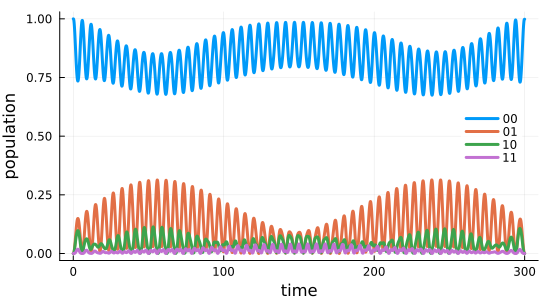

In [ ]:
plot_population1(obs00, obs01, obs10, obs11, tlist)

In [ ]:

obs200 = Float64[]
obs201 = Float64[]
obs210 = Float64[]
obs211 = Float64[]
psi_tj=ket_01
for i in 1:3000
    opt = opt_result_LBFGSB.optimized_controls[1][i]
    opt2 = opt_result_LBFGSB.optimized_controls[2][i]
    H_t = (-0.5) *( omega1 * Iσ̂_z +  omega2 * σ̂_zI )+ J* (σ̂_z_z ) + opt * Iσ̂_x  + opt2 * σ̂_xI
    U = exp(-1im * H_t * dt)
    psi_tj= U * psi_tj

    psi_t00= dot(bra_00 ,psi_tj)
    psi_t01= dot(bra_01 ,psi_tj)
    psi_t10= dot(bra_10 ,psi_tj)
    psi_t11= dot(bra_11 ,psi_tj)
    psi2_t00j= abs.(psi_t00[1]).^2
    psi2_t01j= abs.(psi_t01[1]).^2
    psi2_t10j= abs.(psi_t10[1]).^2
    psi2_t11j= abs.(psi_t11[1]).^2

    append!(obs200,psi2_t00j)
    append!(obs201,psi2_t01j)
    append!(obs210,psi2_t10j)
    append!(obs211,psi2_t11j)
end

println(obs200)
println(obs201)
println(obs210)
println(obs211)

[3.9442796292784093e-7, 2.2387818550597103e-5, 0.0003202156930110371, 0.001422778552940782, 0.0034344109346223953, 0.006304452263289573, 0.010005056299912968, 0.01449501513693799, 0.019720569047998984, 0.02561648212836895, 0.032107347354096795, 0.03910908080907948, 0.04653056231340008, 0.05427537828478084, 0.06224362213961355, 0.07033370770590915, 0.07844415187943926, 0.0864752841118269, 0.09433084238210289, 0.10191941825631479, 0.10915571770548971, 0.11596160973667716, 0.12226694172635166, 0.12801010863308485, 0.13313837284119884, 0.13760794189504855, 0.14138382228884222, 0.14443947809498983, 0.1467563327685991, 0.14832316016339697, 0.14913541590752696, 0.1491945622369211, 0.148507437808797, 0.1470857188282681, 0.14494550922335525, 0.14210708609774683, 0.13859481303855928, 0.1344372190251676, 0.12966722576910283, 0.12432249244400907, 0.1184458350078325, 0.11208566859212232, 0.10529641641666355, 0.09813882776840638, 0.09068015082085089, 0.08299411319206629, 0.07516067357241381, 0.06726

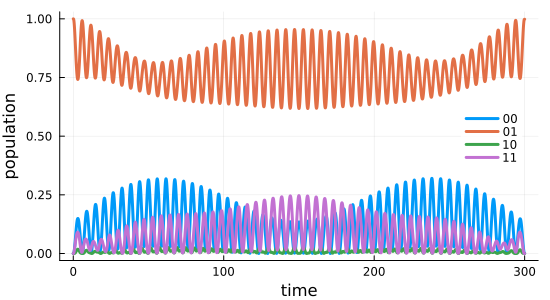

In [ ]:
plot_population1(obs200, obs201, obs210, obs211, tlist)

In [ ]:

obs300 = Float64[]
obs301 = Float64[]
obs310 = Float64[]
obs311 = Float64[]
psi_tj=ket_10
for i in 1:3000
    opt = opt_result_LBFGSB.optimized_controls[1][i]
    opt2 = opt_result_LBFGSB.optimized_controls[2][i]
    H_t = (-0.5) *( omega1 * Iσ̂_z +  omega2 * σ̂_zI )+ J* (σ̂_z_z ) + opt * Iσ̂_x  + opt2 * σ̂_xI

    U = exp(-1im * H_t * dt)
    psi_tj= U * psi_tj

    psi_t00= dot(bra_00 ,psi_tj)
    psi_t01= dot(bra_01 ,psi_tj)
    psi_t10= dot(bra_10 ,psi_tj)
    psi_t11= dot(bra_11 ,psi_tj)
    psi2_t00j= abs.(psi_t00[1]).^2
    psi2_t01j= abs.(psi_t01[1]).^2
    psi2_t10j= abs.(psi_t10[1]).^2
    psi2_t11j= abs.(psi_t11[1]).^2

    append!(obs300,psi2_t00j)
    append!(obs301,psi2_t01j)
    append!(obs310,psi2_t10j)
    append!(obs311,psi2_t11j)
end

println(obs300)
println(obs301)
println(obs310)
println(obs311)

[1.1841507926691063e-6, 2.94389610722042e-5, 0.00033740497072229234, 0.0014075932750363745, 0.003280166180096361, 0.005851336057442447, 0.00904623211037689, 0.01278368745689416, 0.016978686273066822, 0.02154471687186649, 0.026395947515147792, 0.03144915575652144, 0.036625358346834724, 0.04185110616959819, 0.0470594262927985, 0.052190410092665084, 0.05719146173670592, 0.06201723451202121, 0.06662929317139074, 0.07099554848241302, 0.0750895155379557, 0.07888945030661113, 0.08237741965501638, 0.08553835898295337, 0.08835916898237876, 0.09082789910736362, 0.09293306028290778, 0.09466310325952958, 0.09600609184313409, 0.09694959197183287, 0.09748078826736091, 0.09758682932171527, 0.09725539176618545, 0.09647544143040813, 0.09523815810811792, 0.09353797922043794, 0.09137370772964547, 0.08874962177923613, 0.0856765184714039, 0.08217262259186156, 0.07826429342627785, 0.07398646930684985, 0.06938280010811089, 0.06450543218230961, 0.059414427475187825, 0.054176817804531006, 0.048865315320760265,

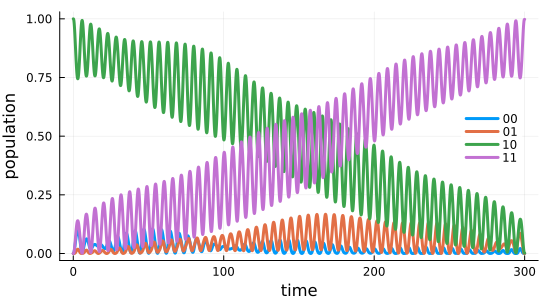

In [ ]:
plot_population1(obs300, obs301, obs310, obs311, tlist)

In [ ]:

obs400 = Float64[]
obs401 = Float64[]
obs410 = Float64[]
obs411 = Float64[]
psi_tj=ket_11
for i in 1:3000
    opt = opt_result_LBFGSB.optimized_controls[1][i]
    opt2 = opt_result_LBFGSB.optimized_controls[2][i]
    H_t = (-0.5) *( omega1 * Iσ̂_z +  omega2 * σ̂_zI )+ J* (σ̂_z_z ) + opt * Iσ̂_x  + opt2 * σ̂_xI
    U = exp(-1im * H_t * dt)
    psi_tj= U * psi_tj

    psi_t00= dot(bra_00 ,psi_tj)
    psi_t01= dot(bra_01 ,psi_tj)
    psi_t10= dot(bra_10 ,psi_tj)
    psi_t11= dot(bra_11 ,psi_tj)
    psi2_t00j= abs.(psi_t00[1]).^2
    psi2_t01j= abs.(psi_t01[1]).^2
    psi2_t10j= abs.(psi_t10[1]).^2
    psi2_t11j= abs.(psi_t11[1]).^2

    append!(obs400,psi2_t00j)
    append!(obs401,psi2_t01j)
    append!(obs410,psi2_t10j)
    append!(obs411,psi2_t11j)
end

println(obs400)
println(obs401)
println(obs410)
println(obs411)

[4.67031988237328e-13, 6.58959640461631e-10, 1.0806791319813239e-7, 2.0070179194964175e-6, 1.1330074824666604e-5, 3.728908946879701e-5, 9.208159123043657e-5, 0.00018999410819483408, 0.0003464172766377729, 0.0005768064055560989, 0.0008956437143556296, 0.0013154548651971032, 0.001845926284706488, 0.0024931617940363074, 0.0032591079821510196, 0.004141168287326626, 0.005132016529848671, 0.006219612153279488, 0.007387411991687362, 0.008614767107890544, 0.009877488096512546, 0.011148558042236897, 0.012398968826329996, 0.013598653438050477, 0.014717484184932985, 0.01572630412675218, 0.01659795673642639, 0.017308276909009657, 0.017837005304561098, 0.018168588001083702, 0.018292824941580427, 0.01820533402321359, 0.017907803118791206, 0.017408009894708608, 0.016719598844863376, 0.01586161613079771, 0.0148578150340931, 0.013735757348647099, 0.012525748015568536, 0.01125965083775473, 0.00996964134858722, 0.008686958112841585, 0.007440715364974968, 0.0062568376512133666, 0.00515717103997363, 0.0041

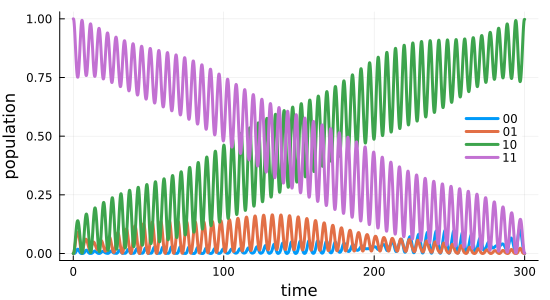

In [ ]:
plot_population1(obs400, obs401, obs410, obs411, tlist)